**# Projeto Final ‚Äì Bootcamp CDIA (UniSENAI SC)**  
## Manuten√ß√£o Preditiva (Multiclass)

**Objetivo:** desenvolver um sistema preditivo capaz de identificar o **tipo de falha principal** em m√°quinas industriais (multiclass)

**Entregas:** gerar `predicoes_multiclass.csv` com as **probabilidades por defeito** (`FDF`,`FDC`,`FP`,`FTE`,`FA`) para o conjunto de teste.

> Este notebook √© o registro ddo desenvolvimento do projeto cuja ideia √© mostrar o caminho, o   racioc√≠nio e o passo a passoseguido para desenvolver o mesmo.


**O que foi usado**:
- ColumnTransformer para separar num√©ricas e categ√≥ricas
- Pipeline para organizar pr√©-processamento + modelo
- valida√ß√£o com StratifiedKFold
- import√¢ncia de calibrar probabilidades quando a gente usa threshold

**Etapas seguidas no notebook, de acordo com as demandas do projeto**

1. Contexto e carregamento de dados  
2. Prepara√ß√£o dos r√≥tulos (bin√°rios ‚Üí multiclass com prioridade)  
3. EDA (seaborn+matplotlib): distribui√ß√£o, correla√ß√£o, classes  
4. Engenharia de atributos  
5. Split e valida√ß√£o (holdout + k-fold)  
6. Testes de modelos multiclass (Logistic Multinomial, RandomForest, GradientBoosting)  
7. Curvas ROC/PR (One-vs-Rest) por classe  
8. Threshold tuning (ganho de F1): regra de rejei√ß√£o para `NONE`  
9. Calibra√ß√£o de probabilidades (CalibratedClassifierCV) para RF/GB  
10. Matriz de confus√£o normalizada e Top-Loss cases  
11. Explainability (Permutation Importance)  
12. Treino final e gera√ß√£o da submiss√£o (`predicoes_multiclass.csv`)  
13. (Extra) Mini dashboard com Streamlit  



## 1) Setup do ambiente
Instala√ß√£o das depend√™ncias e importa√ß√£o das bibliotecas.

In [1]:
%pip uninstall -y opencv-python opencv-contrib-python opencv-python-headless thinc umap-learn tsfresh

Found existing installation: opencv-python 4.12.0.88
Uninstalling opencv-python-4.12.0.88:
  Successfully uninstalled opencv-python-4.12.0.88
Found existing installation: opencv-contrib-python 4.12.0.88
Uninstalling opencv-contrib-python-4.12.0.88:
  Successfully uninstalled opencv-contrib-python-4.12.0.88
Found existing installation: opencv-python-headless 4.12.0.88
Uninstalling opencv-python-headless-4.12.0.88:
  Successfully uninstalled opencv-python-headless-4.12.0.88
Found existing installation: thinc 8.3.6
Uninstalling thinc-8.3.6:
  Successfully uninstalled thinc-8.3.6
Found existing installation: umap-learn 0.5.9.post2
Uninstalling umap-learn-0.5.9.post2:
  Successfully uninstalled umap-learn-0.5.9.post2
Found existing installation: tsfresh 0.21.0
Uninstalling tsfresh-0.21.0:
  Successfully uninstalled tsfresh-0.21.0


In [1]:
!pip install -U "pip>=24.0" "setuptools>=70" "wheel>=0.43"
!pip install -U "numpy>=2,<2.3" "scipy>=1.14" "scikit-learn>=1.6" \
  opencv-python==4.12.0.88 opencv-contrib-python==4.12.0.88 opencv-python-headless==4.12.0.88 \
  thinc==8.3.6 umap-learn==0.5.9.post2

  Using cached numpy-2.2.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached scikit_learn-1.7.1-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
  Using cached opencv_contrib_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
  Using cached opencv_python_headless-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
  Using cached thinc-8.3.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (15 kB)
  Using cached umap_learn-0.5.9.post2-py3-none-any.whl.metadata (25 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (67.0 MB)
Using cached opencv_contrib_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (73.2 MB)
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

In [ ]:
pip install -U numpy pandas scipy scikit-learn seaborn matplotlib


### Seed e ajustes de visualiza√ß√£o

Defino uma semente fixa para reprodutibilidade e aumento a largura do `display` do Pandas para enxergar mais colunas.


### Modelos que testei e por qu√™

- **LogisticRegression**: baseline linear e r√°pido para comparar  
- **RandomForest**: lida bem com n√£o-linearidade e intera√ß√µes  
- **GradientBoosting**: bom para ajustes finos, √†s vezes melhor em F1 macro

### Valida√ß√£o estratificada (K-Fold com mesma propor√ß√£o)

Uso StratifiedKFold para manter a propor√ß√£o das classes em cada dobras, j√° que temos desbalanceamento.  
M√©tricas: **macro-F1** e **ROC-AUC OvR** para avaliar desempenho geral.

### Relat√≥rios e matriz de confus√£o (onde estou errando)

Aqui interpreto onde o modelo erra mais.  
> Uma observa√ß√£o pr√©via √© que: se uma classe for cr√≠tica no neg√≥cio, posso usar class_weight ou threshold tuning nessa classe.


### Curvas ROC/PR (o que eu olho)

- **ROC** √© √∫til no geral, mas com classes desbalanceadas eu olho bastante **PR** (m√©dia de precis√£o para diferentes recalls).  
- Para decis√£o final, posso ajustar **threshold por classe** em vez de usar 0.5.

### Calibra√ß√£o de probabilidades (se eu usar threshold)

Se eu for usar as **probabilidades** para decidir com threshold, faz sentido calibrar (Platt/Isotonic) e checar a curva de calibra√ß√£o.  
Nem sempre melhora, mas ajuda quando as probabilidades est√£o ‚Äúotimistas‚Äù demais.

In [1]:
#Importa√ß√£o das bibliotecas necess√°rias para an√°lise de dados, visualiza√ß√£o e modelagem preditiva

import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

from google.colab import files

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, f1_score, roc_auc_score, log_loss,
                             precision_recall_curve, roc_curve, average_precision_score)

from sklearn.inspection import permutation_importance

#Defini√ß√£o da semente aleat√≥ria e configura√ß√£o de exibi√ß√£o do Pandas

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
pd.set_option("display.max_columns", 200)


**O que eu entendi da matriz de confus√£o:**  
- Onde aparecem mais **falsos positivos** e **falsos negativos**?  
- Tem classe sendo **quase sempre confundida** com outra espec√≠fica? (isso pode indicar falta de sinal/feature)  
- Se alguma classe tem poucos exemplos, a matriz pode ficar "vazia" pra ela ‚Äî olho o **relat√≥rio por classe** tamb√©m.

**Minha leitura das curvas:**  
- **ROC** bonita n√£o garante bom desempenho em classe rara. Por isso olho **PR** com carinho.  
- Se a **precis√£o** cai muito quando aumento **recall**, talvez eu precise ajustar **threshold por classe** em vez de usar 0.5.  
- `average_precision` (AP) me d√° um n√∫mero-resumo da PR; bom pra comparar modelos.

**Sobre a calibra√ß√£o:**  
- Se eu for tomar decis√£o com base em **probabilidades**, √© legal que elas estejam calibradas.  
- √Äs vezes o modelo √© **otimista** (probabilidades altas demais). A curva de calibra√ß√£o mostra isso.  
- Nem sempre calibrar melhora F1, mas ajuda quando preciso de **thresholds** mais confi√°veis.

**Minha leitura r√°pida:**  
- Onde o modelo est√° errando mais? Essas classes s√£o importantes no neg√≥cio?  
- Preciso ajustar o `class_weight` ou o **threshold** de alguma classe espec√≠fica?  
- Vale a pena tentar `GB` com outros hiperpar√¢metros ou simplificar o RF?


### Carregando os dados (jeito simples)

Aqui eu leio os CSVs. Observa√ß√£o: no Colab, se eu reabrir o notebook, pode ser preciso montar o Drive ou reenviar os arquivos.  
Usei este caminho porque foi o mais simples no meu ambiente.


In [3]:
import pandas as pd

# Lendo os CSVs que est√£o no diret√≥rio raiz do Colab
df_train = pd.read_csv("bootcamp_train.csv")
df_test  = pd.read_csv("bootcamp_test.csv")

# Conferindo dimens√µes
print("Treino:", df_train.shape)
print("Teste:", df_test.shape)

# Mostrando as 5 primeiras linhas
df_train.head()

Treino: (35260, 15)
Teste: (7173, 9)


id id_produto tipo  temperatura_ar  temperatura_processo  umidade_relativa  \
0   0     L56434    L           298.3                 309.1              90.0   
1   1     L48741    L           298.2                 308.4              90.0   
2   2     L48850    L           298.2                 307.8              90.0   
3   3     M20947    M           300.9                 310.8              90.0   
4   4     L53849    L           -36.0                 310.5              90.0   

   velocidade_rotacional  torque  desgaste_da_ferramenta falha_maquina  \
0                 1616.0    31.1                   195.0           n√£o   
1                 1388.0    53.8                   137.0           N√£o   
2                 1528.0    31.1                     NaN           N√£o   
3                 1599.0    33.0                     7.0           n√£o   
4                 1571.0    33.9                     NaN           n√£o   

  FDF (Falha Desgaste Ferramenta) FDC (Falha Dissipacao Calor)  \
0                           False                        False   
1                           False                        False   
2                               N                        False   
3                           False                        False   
4                               N                        False   

  FP (Falha Potencia)  FTE (Falha Tensao Excessiva) FA (Falha Aleatoria)  
0                 N√£o                         False                  N√£o  
1                 N√£o                         False                  N√£o  
2                 N√£o                         False                  N√£o  
3                 N√£o                         False                  n√£o  
4                 n√£o                         False                  N√£o

### (Extra) Mini app com Streamlit (ter no√ß√£o de previs√µes)

Inclu√≠ um rascunho de app para ter no√ß√£o de previs√µes. √â simples, mas me ajuda a ‚Äúver‚Äù o modelo fora do notebook.

In [4]:
df_train.head(3)

id id_produto tipo  temperatura_ar  temperatura_processo  umidade_relativa  \
0   0     L56434    L           298.3                 309.1              90.0   
1   1     L48741    L           298.2                 308.4              90.0   
2   2     L48850    L           298.2                 307.8              90.0   

   velocidade_rotacional  torque  desgaste_da_ferramenta falha_maquina  \
0                 1616.0    31.1                   195.0           n√£o   
1                 1388.0    53.8                   137.0           N√£o   
2                 1528.0    31.1                     NaN           N√£o   

  FDF (Falha Desgaste Ferramenta) FDC (Falha Dissipacao Calor)  \
0                           False                        False   
1                           False                        False   
2                               N                        False   

  FP (Falha Potencia)  FTE (Falha Tensao Excessiva) FA (Falha Aleatoria)  
0                 N√£o                         False                  N√£o  
1                 N√£o                         False                  N√£o  
2                 N√£o                         False                  N√£o

## 3) Alvos ‚Äì de 5 r√≥tulos bin√°rios para **Multiclass (6 classes)**
**Motiva√ß√£o:** o desafio solicita testar **multiclass**. Criamos um alvo √∫nico por amostra com as classes:  
`NONE` (sem falha), `FDF`, `FDC`, `FP`, `FTE`, `FA`.  
Para raros casos de m√∫ltiplas falhas na mesma linha, aplicamos **prioridade** (seguran√ßa > t√©rmico > pot√™ncia > desgaste > aleat√≥rio):
`FTE > FDC > FP > FDF > FA`.

In [5]:
LABEL_RAW = [
    "FDF (Falha Desgaste Ferramenta)",
    "FDC (Falha Dissipacao Calor)",
    "FP (Falha Potencia)",
    "FTE (Falha Tensao Excessiva)",
    "FA (Falha Aleatoria)",
]

def to01(v):
    s = str(v).strip().lower()
    if s in {"true","sim","1","y","yes"}: return 1
    if s in {"false","nao","n√£o","0","n","-"}: return 0
    return 0  # fallback conservador

Y_bin = df_train[LABEL_RAW].applymap(to01)
Y_bin.describe()

/tmp/ipython-input-3033553790.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  Y_bin = df_train[LABEL_RAW].applymap(to01)


FDF (Falha Desgaste Ferramenta)  FDC (Falha Dissipacao Calor)  \
count                     35260.000000                  35260.000000   
mean                          0.002014                      0.006381   
std                           0.044829                      0.079628   
min                           0.000000                      0.000000   
25%                           0.000000                      0.000000   
50%                           0.000000                      0.000000   
75%                           0.000000                      0.000000   
max                           1.000000                      1.000000   

       FP (Falha Potencia)  FTE (Falha Tensao Excessiva)  FA (Falha Aleatoria)  
count         35260.000000                  35260.000000          35260.000000  
mean              0.003573                      0.004821              0.002099  
std               0.059672                      0.069269              0.045764  
min               0.000000                      0.000000              0.000000  
25%               0.000000                      0.000000              0.000000  
50%               0.000000                      0.000000              0.000000  
75%               0.000000                      0.000000              0.000000  
max               1.000000                      1.000000              1.000000

### Desbalanceamento (classe Maior  vs. classes pequenas)

As classes est√£o bem desbalanceadas (a `NONE` domina). Para n√£o esconder as menores, uso **escala log no eixo Y** ou gr√°fico em %.

In [6]:
CLASSES = ["NONE","FDF","FDC","FP","FTE","FA"]
PRIORITY = ["FTE","FDC","FP","FDF","FA"]  # maior prioridade ‚Üí menor

RAW2TAG = {
    "FDF (Falha Desgaste Ferramenta)":"FDF",
    "FDC (Falha Dissipacao Calor)":"FDC",
    "FP (Falha Potencia)":"FP",
    "FTE (Falha Tensao Excessiva)":"FTE",
    "FA (Falha Aleatoria)":"FA",
}

def to_multiclass(row):
    if row.sum()==0: return "NONE"
    for tag in PRIORITY:
        raw = [k for k,v in RAW2TAG.items() if v==tag][0]
        if row[raw]==1: return tag
    return "NONE"

y_mc = Y_bin.apply(to_multiclass, axis=1)
y_mc.value_counts()

NONE    34612
FDC       219
FTE       170
FP        117
FA         73
FDF        69
Name: count, dtype: int64

**Minha leitura (r√°pida) do gr√°fico acima:**  
- Parece que tem **uma classe bem maior** (tipo a `NONE`) e v√°rias **bem menores**.  
- Pra n√£o perder as pequenas, costumo usar **escala log** no eixo Y ou plotar em **percentual**.  
- Observa√ß√£o: se a classe menor for cr√≠tica no neg√≥cio, vale pensar em `class_weight` ou reamostragem.

## 4) EDA ‚Äì an√°lise explorat√≥ria com seaborn + matplotlib
- **Sanidade**: tipos, nulos, estat√≠sticas.  
- **Distribui√ß√£o**: histogramas/boxplots das num√©ricas.  
- **Correla√ß√£o**: heatmap.  
- **Classes**: distribui√ß√£o de `y_mc` (multiclass).


In [7]:
ID_COLS  = ["id","id_produto","tipo"]
NUM_COLS = ["temperatura_ar","temperatura_processo","umidade_relativa",
            "velocidade_rotacional","torque","desgaste_da_ferramenta"]

df_train[ID_COLS + NUM_COLS].info()
print("\nNulos por coluna:")
print(df_train[ID_COLS + NUM_COLS].isna().sum().sort_values(ascending=False))
df_train[NUM_COLS].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35260 entries, 0 to 35259
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      35260 non-null  int64  
 1   id_produto              35260 non-null  object 
 2   tipo                    35260 non-null  object 
 3   temperatura_ar          34644 non-null  float64
 4   temperatura_processo    34661 non-null  float64
 5   umidade_relativa        35260 non-null  float64
 6   velocidade_rotacional   34509 non-null  float64
 7   torque                  34637 non-null  float64
 8   desgaste_da_ferramenta  34308 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 2.4+ MB

Nulos por coluna:
desgaste_da_ferramenta    952
velocidade_rotacional     751
torque                    623
temperatura_ar            616
temperatura_processo      599
id                          0
tipo                        0
id_produto        

temperatura_ar  temperatura_processo  umidade_relativa  \
count    34644.000000          34661.000000      35260.000000   
mean       269.535241            280.457676         89.997672   
std         96.342224             96.943630          0.142191   
min        -36.000000            -38.000000         80.590429   
25%        297.900000            308.500000         90.000000   
50%        299.600000            309.800000         90.000000   
75%        301.100000            310.900000         90.000000   
max        304.500000            313.800000         94.575256   

       velocidade_rotacional        torque  desgaste_da_ferramenta  
count           34509.000000  34637.000000            34308.000000  
mean             1380.194181     40.210357               74.373266  
std               494.098759      8.831626              110.411937  
min              -161.000000      3.800000             -202.000000  
25%              1408.000000     34.300000               28.000000  
50%              1483.000000     40.300000               94.000000  
75%              1574.000000     46.200000              155.000000  
max              2886.000000     76.600000              253.000000

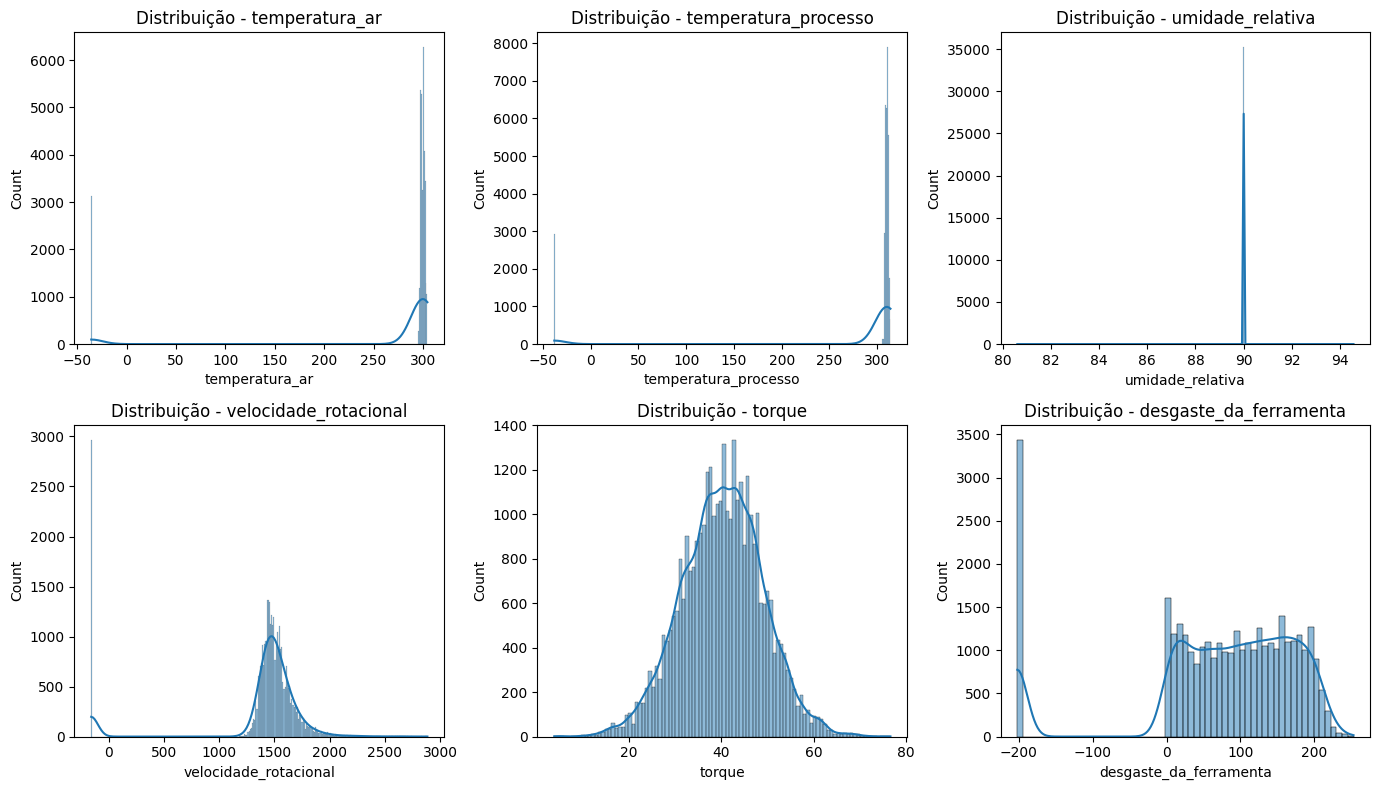

In [8]:
# Histograma para vari√°veis num√©ricas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14,8))
axes = axes.ravel()
for i, c in enumerate(NUM_COLS):
    sns.histplot(df_train[c], kde=True, ax=axes[i])
    axes[i].set_title(f"Distribui√ß√£o - {c}")
plt.tight_layout(); plt.show()

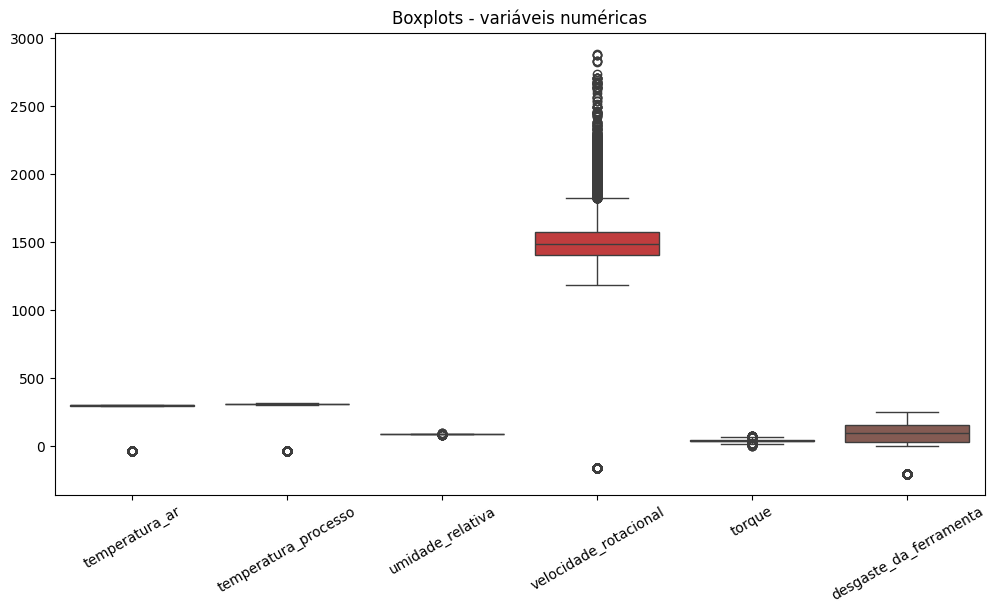

In [9]:
# Boxplots
plt.figure(figsize=(12,6))
sns.boxplot(data=df_train[NUM_COLS])
plt.title("Boxplots - vari√°veis num√©ricas")
plt.xticks(rotation=30)
plt.show()

Abaixo apresentamos a distribu√ß√£o na escala de log, para tornar mais vis√≠vel.

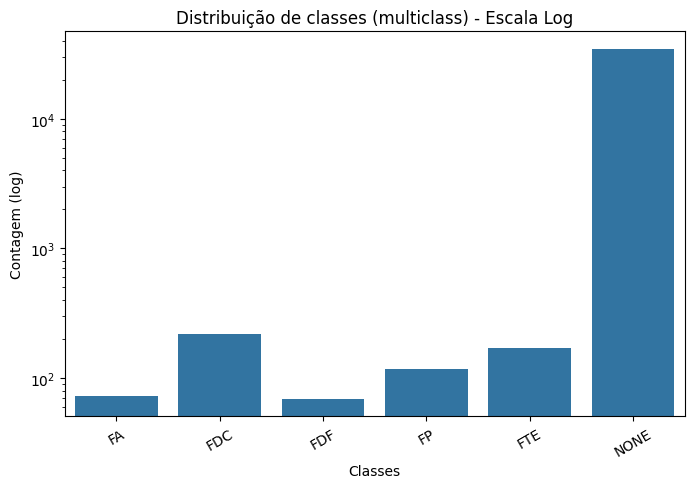

In [12]:
# Distribui√ß√£o por calsses

plt.figure(figsize=(8,5))
sns.countplot(x=y_mc, order=sorted(y_mc.unique()))
plt.yscale("log")  # deixa o eixo Y em escala logar√≠tmica
plt.title("Distribui√ß√£o de classes (multiclass) - Escala Log")
plt.xlabel("Classes")
plt.ylabel("Contagem (log)")
plt.xticks(rotation=30)
plt.show()

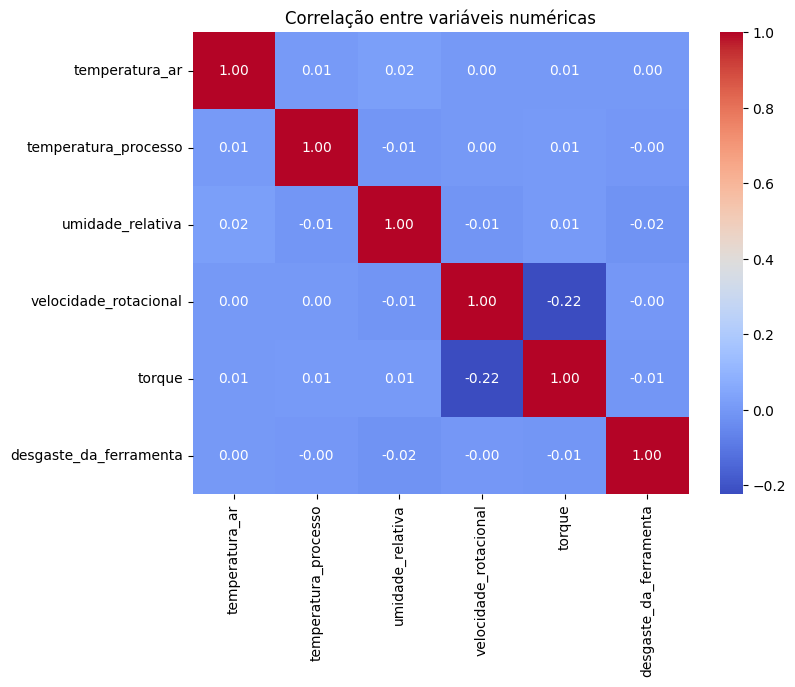

In [11]:
# Correla√ß√£o
plt.figure(figsize=(8,6))
sns.heatmap(df_train[NUM_COLS].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correla√ß√£o entre vari√°veis num√©ricas")
plt.show()

### 5) Engenharia de atributos
Aqui eu criei algumas vari√°veis novas a partir das originais, tentando dar um sentido f√≠sico pra elas:

- delta_temp: diferen√ßa entre a temperatura do processo e a do ar  
-`power_proxy: torque multiplicado pela rota√ß√£o  
- torque_per_rpm: torque dividido pelo rpm  
- wear_per_power: desgaste dividido pela raiz quadrada do power_proxy  
- num_produto: peguei s√≥ os n√∫meros do id_produto


In [13]:
def engineer_features(df):
    out = df.copy()
    out["num_produto"] = out["id_produto"].astype(str).str.extract(r"(\d+)").fillna("0").astype(int)
    out["delta_temp"] = out["temperatura_processo"] - out["temperatura_ar"]
    out["power_proxy"] = out["torque"] * out["velocidade_rotacional"]
    rpm = out["velocidade_rotacional"].replace(0, np.nan)
    out["torque_per_rpm"] = (out["torque"] / rpm).replace([np.inf, -np.inf], np.nan).fillna(0.0)
    out["wear_per_power"] = out["desgaste_da_ferramenta"] / (np.sqrt(out["power_proxy"]) + 1e-6)
    return out

df_train_fe = engineer_features(df_train)
df_test_fe  = engineer_features(df_test)

CAT_COLS  = ["tipo"]
FEAT_COLS = ID_COLS + NUM_COLS + ["num_produto","delta_temp","power_proxy","torque_per_rpm","wear_per_power"]

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


## 6) Split (holdout) e pr√©-processamento
Holdout 80/20 *estratificado* por `y_mc` + `ColumnTransformer` com scaler (num√©ricos) e one-hot (categ√≥ricos).


In [14]:
X = df_train_fe[FEAT_COLS]
y = y_mc

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), [c for c in FEAT_COLS if c not in CAT_COLS]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), CAT_COLS),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

## 7) Testes de modelos (multiclass) com valida√ß√£o cruzada
Modelos testados:  
- **LogisticRegression** (multinomial, softmax) ‚Üí boas probabilidades/calibra√ß√£o.  
- **RandomForest** ‚Üí robusto, n√£o-linear.  
- **GradientBoosting** ‚Üí forte em tabular.

M√©tricas: **accuracy**, **macro-F1** (balanceia classes), **log-loss** (calibra√ß√£o).  

In [ ]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import pandas as pd

# ============================
# 1. Definir scorers
# ============================
scorers = {
    "accuracy": "accuracy",
    "f1_macro": make_scorer(f1_score, average="macro"),
    "neg_log_loss": "neg_log_loss"
}

# ============================
# 2. Definir modelos
# ============================
models = {
    "logreg_multinomial": LogisticRegression(
        multi_class="multinomial", solver="lbfgs", max_iter=2000,
        class_weight="balanced", random_state=RANDOM_SEED
    ),
    "random_forest": RandomForestClassifier(
        n_estimators=500, max_depth=None, min_samples_leaf=1,
        class_weight="balanced_subsample", random_state=RANDOM_SEED, n_jobs=-1
    ),
    "grad_boost": GradientBoostingClassifier(random_state=RANDOM_SEED)
}

# ============================
# 3. Pr√©-processamento com imputa√ß√£o
# ============================
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns

pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols)
    ]
)

# ============================
# 4. Fun√ß√£o de avalia√ß√£o
# ============================
def evaluate_cv(model, X, y, pre, scorers=scorers, n_splits=5, random_state=RANDOM_SEED):
    """Avalia modelo com cross-validation e retorna m√©tricas (m√©dia e std)."""
    pipe = Pipeline([("pre", pre), ("clf", model)])
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    scores = cross_validate(pipe, X, y, cv=cv, scoring=scorers, return_train_score=False)

    results = {}
    for k in scorers:
        results[f"cv_{k}_mean"] = float(scores[f"test_{k}"].mean())
        results[f"cv_{k}_std"] = float(scores[f"test_{k}"].std())
    return results

# ============================
# 5. Rodar avalia√ß√£o
# ============================
results = {}
for name, mdl in models.items():
    print(f"üîé Avaliando {name}...")
    results[name] = evaluate_cv(mdl, X, y, pre)

# ============================
# 6. Resultado final em DataFrame
# ============================
results_df = pd.DataFrame(results).T.sort_values(by="cv_f1_macro_mean", ascending=False)
display(results_df)


üîé Avaliando logreg_multinomial...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

üîé Avaliando random_forest...


## 8) Treino no holdout + Relat√≥rios e Matriz de Confus√£o
Relat√≥rios por classe (precision/recall/F1) e **matriz de confus√£o normalizada**.

In [ ]:
def fit_and_report(name, model, X_train, y_train, X_valid, y_valid, pre):
    pipe = Pipeline([("pre", pre), ("clf", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_valid)
    y_proba = pipe.predict_proba(X_valid)

    acc  = accuracy_score(y_valid, y_pred)
    f1m  = f1_score(y_valid, y_pred, average="macro")
    ll   = log_loss(y_valid, y_proba, labels=sorted(np.unique(y_valid)))
    try:
        auc = roc_auc_score(pd.get_dummies(y_valid), y_proba, multi_class="ovr", average="macro")
    except Exception:
        auc = np.nan

    print(f"\n[{name}] ACC={acc:.4f}  F1_macro={f1m:.4f}  LogLoss={ll:.4f}  ROC-AUC_ovr_macro={auc:.4f}")
    print(classification_report(y_valid, y_pred, digits=4))

    plt.figure(figsize=(6,5))
    ConfusionMatrixDisplay.from_estimator(pipe, X_valid, y_valid,
                                          display_labels=sorted(np.unique(y_valid)),
                                          cmap="Blues", normalize="true")
    plt.title(f"Matriz de confus√£o normalizada ‚Äì {name}")
    plt.show()

    return pipe, {"acc":acc, "f1_macro":f1m, "logloss":ll, "auc_macro":auc}

fitted = {}
summ = {}
for name, mdl in models.items():
    pipe, met = fit_and_report(name, mdl, X_train, y_train, X_valid, y_valid, pre)
    fitted[name] = pipe
    summ[name] = met

pd.DataFrame(summ).T



## 9) Curvas ROC e Precision-Recall por classe (OvR)
Avaliamos curvas **ROC** e **PR** para cada classe (tratando cada uma como positiva vs todas as demais).


In [ ]:
best_name = max(summ, key=lambda k: (summ[k]["f1_macro"], -summ[k]["logloss"]))
best_pipe = fitted[best_name]
print("Melhor modelo (holdout):", best_name)

y_proba = best_pipe.predict_proba(X_valid)
classes_order = best_pipe.named_steps["clf"].classes_
proba_df = pd.DataFrame(y_proba, columns=classes_order, index=y_valid.index)

for cls in classes_order:
    y_true_bin = (y_valid == cls).astype(int)
    y_score = proba_df[cls].values

    fpr, tpr, _ = roc_curve(y_true_bin, y_score)
    prec, rec, _ = precision_recall_curve(y_true_bin, y_score)
    ap = average_precision_score(y_true_bin, y_score)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--',alpha=0.6)
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC ‚Äì classe {cls}")
    plt.show()

    plt.figure(figsize=(5,4))
    plt.plot(rec, prec)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR ‚Äì classe {cls} (AP={ap:.3f})")
    plt.show()


## 10) Threshold tuning (ganho de F1) ‚Äì Gate para `NONE`
**Ideia:** em vez de sempre usar `argmax`, aplicamos uma **regra de rejei√ß√£o**:  
se `max(prob das classes de defeito) < T`, preveja **`NONE`**; caso contr√°rio, **escolha a classe de defeito com maior probabilidade**.  
Buscamos o melhor **T** no holdout e comparamos o macro-F1.


In [ ]:
DEFECTS = ["FDF","FDC","FP","FTE","FA"]
def predict_with_gate(proba_df, T=0.5):
    out = []
    for i in range(len(proba_df)):
        row = proba_df.iloc[i]
        top_defect = row[DEFECTS].idxmax()
        top_prob   = row[DEFECTS].max()
        pred = top_defect if top_prob >= T else "NONE"
        out.append(pred)
    return np.array(out)

y_pred_argmax = proba_df.idxmax(axis=1).values
f1_argmax = f1_score(y_valid, y_pred_argmax, average="macro")

best_T, best_f1 = 0.0, -1
grid = np.linspace(0.2, 0.8, 13)
f1_hist = []
for T in grid:
    y_pred_gate = predict_with_gate(proba_df, T)
    f1m = f1_score(y_valid, y_pred_gate, average="macro")
    f1_hist.append((T, f1m))
    if f1m > best_f1:
        best_f1, best_T = f1m, T

print(f"F1_macro (argmax puro) = {f1_argmax:.4f}")
print(f"F1_macro (gate NONE)   = {best_f1:.4f}  @T={best_T:.2f}")

# Gr√°fico F1 vs Threshold
thr, f1s = zip(*f1_hist)
plt.figure(figsize=(6,4))
plt.plot(thr, f1s, marker='o')
plt.axhline(f1_argmax, ls='--', alpha=0.6, label='argmax')
plt.axvline(best_T, ls=':', alpha=0.6, label='T*')
plt.title("F1_macro vs Threshold (gate NONE)")
plt.xlabel("Threshold T"); plt.ylabel("F1_macro")
plt.legend(); plt.show()


## 11) Calibra√ß√£o de probabilidades (RF/GB)
Para modelos **RandomForest/GradientBoosting**, calibramos com `CalibratedClassifierCV` (sigmoid).  
Comparamos **log-loss** antes/depois e mostramos **calibration curve** para 1‚Äì2 classes.

In [ ]:
calib_candidates = [("random_forest","rf_calib"), ("grad_boost","gb_calib")]
calib_scores = {}

for base_name, tag in calib_candidates:
    if base_name in fitted:
        base = fitted[base_name]
        Xv = X_valid; yv = y_valid
        pre_only = base.named_steps["pre"]
        est_only = base.named_steps["clf"]
        Xtr_tr = pre_only.fit_transform(X_train, y_train)
        Xv_tr  = pre_only.transform(X_valid)

        calib = CalibratedClassifierCV(est_only, method="sigmoid", cv=3)
        calib.fit(Xtr_tr, y_train)
        y_proba_cal = calib.predict_proba(Xv_tr)
        ll = log_loss(yv, y_proba_cal, labels=sorted(np.unique(yv)))
        try:
            auc = roc_auc_score(pd.get_dummies(yv), y_proba_cal, multi_class="ovr", average="macro")
        except Exception:
            auc = np.nan
        calib_scores[tag] = {"logloss": float(ll), "auc_macro": float(auc)}

calib_scores

In [ ]:
# Curva de calibra√ß√£o para uma classe (ex.: FTE)
cls_show = "FTE"
for tag, scores in calib_scores.items():
    base_name = "random_forest" if "rf_" in tag else "grad_boost"
    base = fitted[base_name]
    pre_only = base.named_steps["pre"]
    est_only = base.named_steps["clf"]
    Xtr_tr = pre_only.fit_transform(X_train, y_train)
    Xv_tr  = pre_only.transform(X_valid)
    calib = CalibratedClassifierCV(est_only, method="sigmoid", cv=3).fit(Xtr_tr, y_train)
    classes_order = calib.classes_
    if cls_show in classes_order:
        idx = list(classes_order).index(cls_show)
        prob = calib.predict_proba(Xv_tr)[:, idx]
        y_true_bin = (y_valid == cls_show).astype(int)
        frac_pos, mean_pred = calibration_curve(y_true_bin, prob, n_bins=10)

        plt.figure(figsize=(5,4))
        plt.plot(mean_pred, frac_pos, marker="o")
        plt.plot([0,1],[0,1],'--',alpha=0.6)
        plt.xlabel("Prob prevista"); plt.ylabel("Fra√ß√£o positiva")
        plt.title(f"Calibration curve ‚Äì {tag} ‚Äì classe {cls_show}")
        plt.show()

## 12) Erros mais custosos no holdout)
Mostramos as **10 piores perdas individuais** (multiclass log-loss por amostra) para an√°lise r√°pida.


In [ ]:
def per_sample_logloss(y_true, proba, classes):
    y_idx = y_true.map({c:i for i,c in enumerate(classes)}).values
    eps = 1e-15
    p_true = np.clip(proba[np.arange(len(y_true)), y_idx], eps, 1-eps)
    return -np.log(p_true)

y_proba_val = best_pipe.predict_proba(X_valid)
classes_order = best_pipe.named_steps["clf"].classes_.tolist()
losses = per_sample_logloss(y_valid, y_proba_val, classes_order)
worst_idx = np.argsort(-losses)[:10]

df_worst = X_valid.iloc[worst_idx].copy()
df_worst["true"] = y_valid.iloc[worst_idx].values
df_worst["pred"] = best_pipe.predict(X_valid.iloc[worst_idx])
df_worst["logloss"] = losses[worst_idx]
df_worst.sort_values("logloss", ascending=False)

## 13) Medimos import√¢ncia de atributos via **Permutation Importance** sobre o holdout.


In [ ]:
r = permutation_importance(best_pipe, X_valid, y_valid, n_repeats=7, random_state=RANDOM_SEED, n_jobs=-1)
feat_names = best_pipe.named_steps["pre"].get_feature_names_out()
imp = pd.Series(r.importances_mean, index=feat_names).sort_values(ascending=True)

plt.figure(figsize=(8,6))
imp.tail(15).plot(kind="barh")
plt.title("Top 15 features por import√¢ncia (Permutation Importance)")
plt.tight_layout(); plt.show()


## 14) Treino final e **submiss√£o**
Treinamos o **melhor modelo** no **conjunto completo de treino** e geramos `predicoes_multiclass.csv` com as **probabilidades por defeito** (`FDF`,`FDC`,`FP`,`FTE`,`FA`) ‚Äî ignorando a probabilidade de `NONE`.


In [ ]:
final_pipe = Pipeline([("pre", pre), ("clf", best_pipe.named_steps["clf"])])
final_pipe.fit(X, y)

proba_test = final_pipe.predict_proba(df_test_fe[FEAT_COLS])
classes_order = final_pipe.named_steps["clf"].classes_.tolist()

want = ["FDF","FDC","FP","FTE","FA"]
sub = pd.DataFrame({"id": df_test_fe["id"].values})
for w in want:
    idx = classes_order.index(w)
    sub[w] = proba_test[:, idx]

sub.head()


In [ ]:
UB_PATH = "predicoes_multiclass.csv"
sub.to_csv(SUB_PATH, index=False)
files.download(SUB_PATH)


## 15) (Extra) Mini dashboard com Streamlit
Demonstra√ß√£o r√°pida de EDA. **Opcional**, diferencial para a banca.

Para rodar fora do Colab (local):
```bash
pip install streamlit
streamlit run app.py
```

No Colab, pode exigir t√∫nel (ngrok/localtunnel). Alternativa: baixe `app.py` e rode localmente.

In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

st.set_page_config(page_title="Manuten√ß√£o Preditiva", layout="wide")
st.title("Dashboard ‚Äì Manuten√ß√£o Preditiva (EDA)")

uploaded_train = st.file_uploader("Carregue o Bootcamp_train.csv", type=["csv"])
if uploaded_train is not None:
    df = pd.read_csv(uploaded_train)
    st.subheader("Amostra dos dados")
    st.dataframe(df.head(20))

    num_cols = df.select_dtypes(include=["float","int"]).columns.tolist()
    if num_cols:
        st.subheader("Distribui√ß√£o de uma vari√°vel num√©rica")
        col = st.selectbox("Escolha a vari√°vel", num_cols)
        fig, ax = plt.subplots()
        sns.histplot(df[col], kde=True, ax=ax)
        st.pyplot(fig)

    st.subheader("Correla√ß√£o (num√©ricas)")
    if num_cols:
        fig, ax = plt.subplots(figsize=(8,6))
        sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f", ax=ax)
        st.pyplot(fig)
else:
    st.info("Aguardando upload do Bootcamp_train.csv")
